In [1]:
# for imports
import sys
sys.path.append('../')

import io, os, sys, cv2, requests, time, json
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from utils.camera import Camera
import torch
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms

In [3]:
# load vgg16 model 
vgg16 = models.vgg16(pretrained=True)  
device = torch.device('cuda')
vgg16 = vgg16.to(device)

In [4]:
# load imagenet labels from internet

# try local file
try:
    print('try to load labels from local file...')
    with open('../images/imagenet_labels.json') as json_file:
        json_data = json.load(json_file)
    
except:
    print('try to load labels from internet...')
    LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
    response = requests.get(LABELS_URL)  
    json_data = response.json()
    

labels = {int(key): value for key, value in json_data.items()}

print(len(labels), 'labels found')

try to load labels from local file...
1000 labels found


In [5]:
# preprocess
def preprocess_image(img):
    start_time= time.time()
    
    min_img_size = 224  
    transform_pipeline = transforms.Compose([
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
        transforms.Resize(min_img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform_pipeline(img)
    # print(type(img_tensor), img_tensor.shape)
    img_tensor = img_tensor.unsqueeze(0)  
    img_tensor = Variable(img_tensor)
    duration = time.time() - start_time
    return img_tensor, duration   

In [6]:
# predict
def predict_from_image_tensor(img_tensor):
    start_time= time.time()
    prediction = vgg16(img_tensor.cuda()).cpu() 
    
    df = pd.DataFrame(data=prediction.data.numpy().reshape(-1)).nlargest(10, 0).reset_index()
    df.columns=['id', 'score']
    df['label'] = df['id'].apply(lambda x : labels[x])

    duration = time.time() - start_time
    return df, duration

## predict image from file

In [7]:
img = Image.open("../images/dog.jpg")
img_tensor, _ = preprocess_image(img)
df, _ = predict_from_image_tensor(img_tensor)
print(df.nlargest(1, 'score')[['label','score']].values[0][0], df.nlargest(1, 'score')[['label','score']].values[0][1])

flat-coated retriever 10.132081031799316


## predict image from internet

In [8]:
urls = ['https://upload.wikimedia.org/wikipedia/commons/b/bb/Kittyply_edit1.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/5/5c/Fox---Vulpes-corsac---%28Gentry%29.jpg',
       'https://upload.wikimedia.org/wikipedia/commons/0/04/VW_Golf_2_Red_ca_1990_dept_54.JPG',
       'https://upload.wikimedia.org/wikipedia/commons/0/0c/Fussball.jpg']

tabby 	 time prepr./pred.:1.28s/0.78s image size (1728, 1152)
kit fox 	 time prepr./pred.:2.92s/0.61s image size (3000, 2250)
beach wagon 	 time prepr./pred.:0.10s/0.86s image size (557, 322)
soccer ball 	 time prepr./pred.:0.05s/0.38s image size (253, 266)


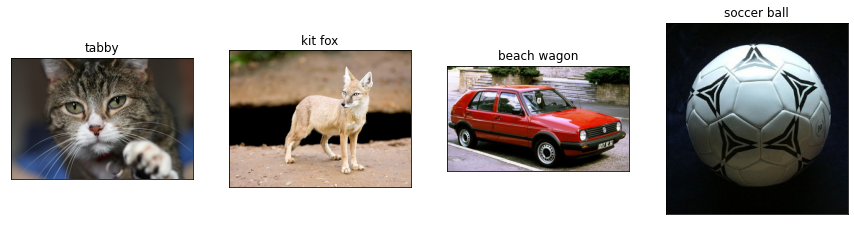

In [9]:
fig = plt.figure(figsize=(15, 10))
for i, url in enumerate(urls):
    # load image
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    
    # predict label
    img_tensor, duration_preprocess = preprocess_image(img)
    df, duration_predict = predict_from_image_tensor(img_tensor)
    pred_label = df.nlargest(1, 'score')[['label','score']].values[0][0].split(',')[0]
    pred_score = df.nlargest(1, 'score')[['label','score']].values[0][1]

    # draw image
    ax = fig.add_subplot(1, len(urls), i + 1)
    plt.imshow(img)
    ax.set_title(pred_label)
    ax.set_xticks([])
    ax.set_yticks([])
    print(f'{pred_label} \t time prepr./pred.:{duration_preprocess:0.2f}s/{duration_predict:0.2f}s image size {img.size}')

## predict image fom camera


In [10]:
# initialize only one time
if 'camera0' not in locals():
    camera0 = Camera(capture_device=0, width=224, height=224, 
                     capture_width=1280, capture_height=720, capture_fps=30, flip_mode=-1, debug=True)



nvarguscamerasrc sensor-id=0 ! video/x-raw(memory:NVMM), width=1280, height=720,                 format=(string)NV12, framerate=(fraction)30/1 ! nvvidconv ! video/x-raw, width=(int)224,                 height=(int)224, format=(string)BGRx ! videoconvert ! appsink drop=true sync=false


In [11]:
img = camera0.get_image_rgb()
img = Image.fromarray(img, 'RGB')
img_tensor, duration_preprocess = preprocess_image(img)
df, duration_predict = predict_from_image_tensor(img_tensor)
pred_label = df.nlargest(1, 'score')[['label','score']].values[0][0].split(',')[0]
print(f'{pred_label} - time preprocess / prediction:{duration_preprocess:0.2f}s / {duration_predict:0.2f}s')

turnstile - time preprocess / prediction:0.77s / 1.32s


## live test camera

In [13]:
duration = 10 # running time in seconds

from IPython.display import display
import ipywidgets.widgets as widgets
image_widget = widgets.Image(format='jpeg', width=300, height=300)
label_widget = widgets.Text(description='detected')
confidence_widget = widgets.Text(description='score')
time_widget = widgets.Text(description='pred. time')
progress_widget = widgets.FloatProgress(value=0, min=0.0, max=float(duration), description='running time')

display(widgets.HBox([image_widget, 
                      widgets.VBox([label_widget, confidence_widget, time_widget, progress_widget])]))

start_time = time.time()
while time.time() - start_time < duration:
    img_rgb = camera0.get_image_rgb()
    img = Image.fromarray(img_rgb, 'RGB')
    img_tensor, duration_preprocess = preprocess_image(img)
    df, duration_predict = predict_from_image_tensor(img_tensor)
    pred_label = df.nlargest(1, 'score')[['label','score']].values[0][0].split(',')[0]
    pred_proba = df.nlargest(1, 'score')[['label','score']].values[0][1]
    label_widget.value = pred_label
    confidence_widget.value = f'{pred_proba:0.0f}'
    time_widget.value = f'{duration_predict:0.2f} sec'
    image_widget.value = bytes(cv2.imencode('.jpg', img_rgb)[1])
    progress_widget.value = (time.time() - start_time)